## MNIST Attribution Input Invariance Experiment

Inspiration for the work in this notebook is the study of Kindermans *et al.* (2017) on **input invariance** of various explainable AI (XAI) methods. 

> "If a constant shift does not change the model’s output, the attributions should remain unchanged."


In [66]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import islice 
from PIL import Image, ImageDraw

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from captum.attr import Saliency, GuidedBackprop, InputXGradient, IntegratedGradients, GradientShap

In [67]:
import matplotlib as mpl # for pdf export
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

In [68]:
torch.manual_seed(0); np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load `MNIST` data

In [69]:
mean, std = 0.1307, 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
test_ds = datasets.MNIST("./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

### CNN Model

In [70]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3), nn.ReLU(),
            nn.Conv2d(32,64,3), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*12*12,128), nn.ReLU(),
            nn.Dropout(0.5), nn.Linear(128,10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x.view(x.size(0), -1))

In [71]:
model = CNN().to(device)
model.load_state_dict(torch.load("ex2_mnist_cnn.pth", map_location=device))
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Twin CNN Model (shifted)
- to ensure it produces the same logits as the original model, we need to adjust the *bias* term of the first conv layer:
  - $x \dots$  input
  - $x' \leftarrow x + m \dots$ *shifted* input

- `conv1` (CNN1): $\quad z  = (w\cdot x  + b)$
- `conv1` (CNN2): $\quad z' = (w\cdot x' + b')$

- we want $z == z'$:
  - $(w \cdot x + b) == (w \cdot (x + m) + b') \iff b' = b - w\cdot m$ 
- adjust bias of `conv1` CNN2 to $b'$

In [72]:
m_val = -1.0 / std
m_tensor = torch.full((1,1,28,28), m_val, device=device)

model2 = copy.deepcopy(model).to(device)
with torch.no_grad():
    conv = model2.features[0]
    w = conv.weight
    b = conv.bias
    w_sum = w.sum(dim=(1,2,3)) # per-filter \sum w
    conv.bias[:] = b - w_sum * m_val
model2.eval()

# Verify functional equivalence on one sample
x0, y0 = next(iter(test_loader))
x0, y0 = x0.to(device), y0.to(device)
with torch.no_grad():
    diff = (model(x0) - model2(x0 + m_tensor)).abs().max().item()
print(f"Max logit difference: {diff:.2e}")

Max logit difference: 1.43e-06


In [73]:
# Verify functional equivalence on multiple samples
with torch.no_grad():
    diffs = []
    for x, _ in islice(test_loader, 128):
        x = x.to(device)
        diff = (model(x) - model2(x + m_tensor)).abs().max().item()
        diffs.append(diff)
    assert max(diffs) < 1e-5, "Twin network not functionally identical"
    print(f"Max logit difference over 128 samples: {max(diffs):.2e}")

Max logit difference over 128 samples: 3.81e-06


### Attribution Methods

In [74]:
methods = {
    "Gradient": Saliency,
    # "GuidedBP": GuidedBackprop,
    # "InputXGrad": InputXGradient,
    "IG-zero": IntegratedGradients,
    "IG-black": IntegratedGradients,
    "GS-zero": GradientShap,
    "GS-black": GradientShap
}

In [75]:
methods1, methods2 = {}, {}
for name, Cls in methods.items():
    methods1[name] = Cls(model)
    methods2[name] = Cls(model2)

In [76]:
label = model(x0).argmax().item()

In [77]:
def compute_attrs(methods_dict, x, shift_tensor=None, do_baseline_shift=False, gs_n_samples=400):
    torch.manual_seed(0) 
    inp = x + (shift_tensor if shift_tensor is not None else 0)
    attrs={}
    for name,mtd in methods_dict.items():
        # Raw baseline
        b = torch.zeros_like(x)
        b = b if name.endswith("-zero") else b.sub(mean).div(std)
        # Only shift baseline when testing constant shift
        b2 = b + (shift_tensor if do_baseline_shift and name.endswith("-black") else 0)
        # Attribution
        if name.startswith("IG"): # Integrated Gradients
            a = mtd.attribute(inp, baselines=(b2 if do_baseline_shift else b), target=label, n_steps=50)
        elif name.startswith("GS"): # GradientSHAP
            sigma = 0.1 # noise std
            base = b2 if do_baseline_shift else b
            # Draw half the noises
            eps = torch.randn(gs_n_samples // 2, 1, 28, 28, device=device)
            # Form positive and negative pairs
            bs_pos = base + sigma * eps
            bs_neg = base - sigma * eps
            # Concatenate to get N samples
            bsamps = torch.cat([bs_pos, bs_neg], dim=0)
            a = mtd.attribute(inp, baselines=bsamps, target=label, n_samples=gs_n_samples)
        else: # Vanilla Gradients
            a = mtd.attribute(inp, target=label, abs=False)
        attrs[name]=a.detach().cpu().squeeze().numpy()
    return attrs

### Constant-shift experiment

In [78]:
# Attributions for CNN1 (original)
attrs1 = compute_attrs(methods1, x0, shift_tensor=None, do_baseline_shift=False, gs_n_samples=12800)
# Attributions for CNN2 (twin model)
attrs2 = compute_attrs(methods2, x0, shift_tensor=m_tensor, do_baseline_shift=True, gs_n_samples=12800)

c:\USERS\SIMON\DESKTOP\DP\CODE\LEARNING\QUANTUS\VENV\lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


### Visualize Attributions

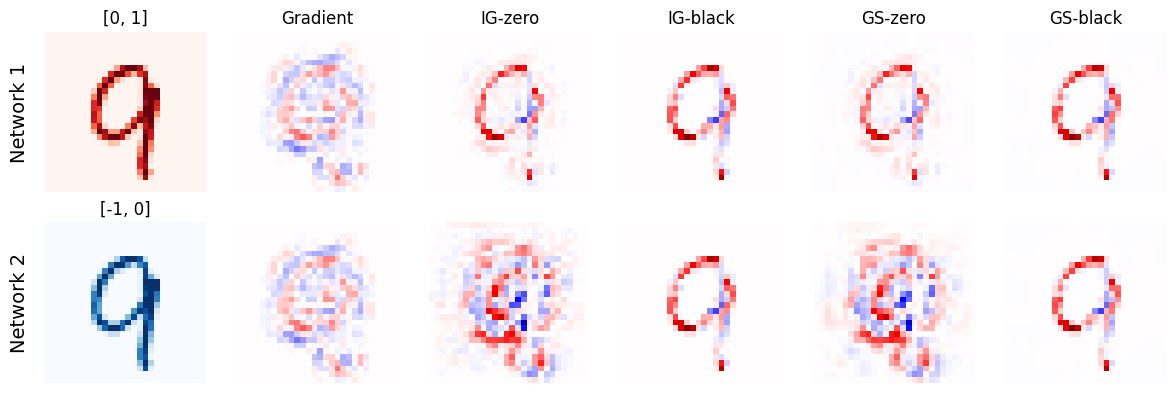

In [79]:
rows = [
    "Gradient", #"GuidedBP", #"InputXGrad",
    "IG-zero",  "IG-black",
    "GS-zero",  "GS-black",
]
n = len(rows)

# denormalized raw images
img1 = (x0 * std + mean).cpu().squeeze().numpy()             # [0,1]
img2 = ((x0 + m_tensor)*std + mean).cpu().squeeze().numpy()  # = x_raw - 1 in [-1,0]

fig, axes = plt.subplots(2, n+1, figsize=(2*(n+1), 4))

axes[0,0].imshow(img1, cmap="Reds",  vmin=0,  vmax=1)
axes[0,0].set_title("[0, 1]"); axes[0,0].axis("off")

axes[1,0].imshow(img2, cmap="Blues", vmin=-1, vmax=0)
axes[1,0].set_title("[-1, 0]"); axes[1,0].axis("off")

for j, name in enumerate(rows, start=1):
    axes[0,j].imshow(attrs1[name], cmap="seismic", vmin=-1, vmax=1)
    axes[0,j].axis("off"); axes[0,j].set_title(name)

    axes[1,j].imshow(attrs2[name], cmap="seismic", vmin=-1, vmax=1)
    axes[1,j].axis("off")

# add row labels
axes[0,0].text(-0.1, 0.5, "Network 1", transform=axes[0,0].transAxes, va="center", ha="right", rotation=90, fontsize=14)
axes[1,0].text(-0.1, 0.5, "Network 2", transform=axes[1,0].transAxes, va="center", ha="right", rotation=90, fontsize=14)

plt.tight_layout()
#plt.savefig("figures/ex3b_input_invariance.pdf", bbox_inches="tight")
plt.show()

In [80]:
# Quantitative check
for n in rows:
    delta = np.abs(attrs1[n]-attrs2[n]).max()
    print(f"{n:8s} max|Δ| = {delta:.3e}")

Gradient max|Δ| = 2.980e-08
IG-zero  max|Δ| = 9.854e-01
IG-black max|Δ| = 2.980e-08
GS-zero  max|Δ| = 9.601e-01
GS-black max|Δ| = 4.233e-03


In [81]:
def invariance_metrics(A1, A2, eps=1e-8):
    diff = A1 - A2
    max_abs_diff = np.max(np.abs(diff))                              # maximum absolute deviation
    mean_abs_diff = np.mean(np.abs(diff))                            # mean absolute deviation
    rmse = np.sqrt(np.mean(diff ** 2))                               # root-mean-square error
    rel_l1_error = np.sum(np.abs(diff)) / (np.sum(np.abs(A1)) + eps) # relative L1 error
    correlation = np.corrcoef(A1.ravel(), A2.ravel())[0, 1]          # Pearson correlation

    return {
        "max_abs_diff": max_abs_diff,
        "mean_abs_diff": mean_abs_diff,
        "rmse": rmse,
        "rel_l1_error": rel_l1_error,
        "correlation": correlation
    }

for name in rows:  # rows = list of method names
    m = invariance_metrics(attrs1[name], attrs2[name])
    print(f"{name:8s}",
          f"max|diff|={m['max_abs_diff']:.2e}",
          f"mean|diff|={m['mean_abs_diff']:.2e}",
          f"RMSE={m['rmse']:.2e}",
          f"relL1={m['rel_l1_error']:.2%}",
          f"corr={m['correlation']:.4f}")


Gradient max|diff|=2.98e-08 mean|diff|=3.11e-10 RMSE=1.85e-09 relL1=0.00% corr=1.0000
IG-zero  max|diff|=9.85e-01 mean|diff|=7.68e-02 RMSE=1.46e-01 relL1=280.54% corr=-0.0682
IG-black max|diff|=2.98e-08 mean|diff|=3.55e-10 RMSE=2.35e-09 relL1=0.00% corr=1.0000
GS-zero  max|diff|=9.60e-01 mean|diff|=7.42e-02 RMSE=1.42e-01 relL1=272.38% corr=-0.0681
GS-black max|diff|=4.23e-03 mean|diff|=1.34e-04 RMSE=4.38e-04 relL1=0.52% corr=1.0000


**Optional**, run multi-sample invariance statistics assessment
> Note: beware computationally heavy

In [82]:
# NOTE: Multi-sample constant-shift invariance statistics
# N = 100 # number of test images
# rows_eval = ["Gradient", "IG-zero", "IG-black", "GS-zero", "GS-black"]

# results = {m: {k: [] for k in ["max_abs_diff",
#                                "mean_abs_diff",
#                                "rmse",
#                                "rel_l1_error",
#                                "correlation"]} for m in rows_eval}

# with torch.no_grad():
#     it = islice(test_loader, N)
#     for x, _ in tqdm(it, total=N, desc="Evaluating invariance"):
#         x = x.to(device)

#         attrs1 = compute_attrs(methods1, x, shift_tensor=None, do_baseline_shift=False, gs_n_samples=12800)
#         attrs2 = compute_attrs(methods2, x, shift_tensor=m_tensor, do_baseline_shift=True, gs_n_samples=12800)

#         for m in rows_eval:
#             r = invariance_metrics(attrs1[m], attrs2[m])
#             for k, v in r.items():
#                 results[m][k].append(v)

# # aggregate
# tbl = []
# for m in rows_eval:
#     row = {"method": m}
#     for k, arr in results[m].items():
#         arr = np.asarray(arr)
#         row[f"{k}_mean"] = arr.mean()
#         row[f"{k}_std"]  = arr.std()
#         row[f"{k}_p95"]  = np.percentile(arr, 95)
#     tbl.append(row)

# df = pd.DataFrame(tbl)

In [83]:
# print(df.to_string(index=False, float_format=lambda x: f"{x:.2e}"))
# method  max_abs_diff_mean  max_abs_diff_std  max_abs_diff_p95  mean_abs_diff_mean  mean_abs_diff_std  mean_abs_diff_p95  rmse_mean  rmse_std  rmse_p95  rel_l1_error_mean  rel_l1_error_std  rel_l1_error_p95  correlation_mean  correlation_std  correlation_p95
# Gradient           4.57e-04          4.54e-03          2.98e-08            4.14e-06           4.12e-05           7.18e-10   2.82e-05  2.81e-04  3.13e-09           1.06e-04          1.05e-03          1.99e-08          1.00e+00         8.99e-05         1.00e+00
#  IG-zero           8.06e-01          2.51e-01          1.28e+00            6.73e-02           1.30e-02           8.64e-02   1.23e-01  2.55e-02  1.62e-01           2.58e+00          4.08e-01          3.44e+00         -2.96e-02         4.65e-02         5.19e-02
# IG-black           3.58e-05          1.92e-04          1.34e-04            2.11e-07           1.17e-06           3.61e-07   2.23e-06  1.24e-05  6.85e-06           1.11e-05          7.41e-05          9.16e-06          1.00e+00         1.63e-07         1.00e+00
#  GS-zero           7.93e-01          2.48e-01          1.26e+00            6.50e-02           1.29e-02           8.34e-02   1.20e-01  2.56e-02  1.60e-01           2.51e+00          3.77e-01          3.25e+00         -2.58e-02         4.89e-02         5.93e-02
# GS-black           5.13e-03          2.08e-03          8.95e-03            1.96e-04           6.92e-05           3.34e-04   5.73e-04  1.87e-04  9.19e-04           7.73e-03          2.32e-03          1.31e-02          1.00e+00         9.12e-06         1.00e+00

In [84]:
# print(df.to_string(index=False))
# method  max_abs_diff_mean  max_abs_diff_std  max_abs_diff_p95  mean_abs_diff_mean  mean_abs_diff_std  mean_abs_diff_p95  rmse_mean  rmse_std     rmse_p95  rel_l1_error_mean  rel_l1_error_std  rel_l1_error_p95  correlation_mean  correlation_std  correlation_p95
# Gradient           0.000457          0.004542      2.980232e-08        4.138693e-06           0.000041       7.175802e-10   0.000028  0.000281 3.126090e-09           0.000106          0.001053      1.992802e-08          0.999991     8.987579e-05         1.000000
#  IG-zero           0.806423          0.250805      1.284830e+00        6.730219e-02           0.012998       8.641309e-02   0.122990  0.025519 1.623798e-01           2.580576          0.408113      3.439022e+00         -0.029582     4.652951e-02         0.051855
# IG-black           0.000036          0.000192      1.337921e-04        2.108275e-07           0.000001       3.607543e-07   0.000002  0.000012 6.852308e-06           0.000011          0.000074      9.155689e-06          1.000000     1.629024e-07         1.000000
#  GS-zero           0.792942          0.247959      1.263623e+00        6.497613e-02           0.012910       8.336019e-02   0.120082  0.025575 1.597282e-01           2.508937          0.377026      3.248122e+00         -0.025777     4.888973e-02         0.059289
# GS-black           0.005126          0.002080      8.951150e-03        1.963050e-04           0.000069       3.337451e-04   0.000573  0.000187 9.193054e-04           0.007734          0.002320      1.308202e-02          0.999984     9.121557e-06         0.999993

### Structured-shift (checkerboard/cat attack)

In [85]:
def make_shift(pattern: str, raw_shift=1.0):
    arr = np.zeros((28,28),dtype=np.float32)
    if pattern=='checker':
        tiles=2; t=28//tiles
        for i in range(tiles):
            for j in range(tiles): 
                arr[i*t:(i+1)*t, j*t:(j+1)*t] = raw_shift*((i+j) % 2)
    else: # cat head pattern
        img=Image.new('L',(28,28),0); d=ImageDraw.Draw(img)
        d.ellipse((6,6,21,21),fill=int(raw_shift*255))
        d.polygon([(6,9),(10,0),(14,9)],fill=int(raw_shift*255)) 
        d.polygon([(21,9),(17,0),(14,9)],fill=int(raw_shift*255))
        arr=np.array(img,dtype=np.float32)/255*raw_shift
    return torch.tensor(arr/std,device=device).unsqueeze(0).unsqueeze(0)

In [86]:
base_attr_orig, base_attr_shifted = {}, {}

Gradient max|diff|=3.41e-01 mean|diff|=2.96e-02 RMSE=5.62e-02 relL1=91.65% corr=0.6096
IG-zero  max|diff|=5.22e-01 mean|diff|=2.82e-02 RMSE=6.68e-02 relL1=102.82% corr=0.8030
IG-black max|diff|=5.54e-01 mean|diff|=3.25e-02 RMSE=7.97e-02 relL1=124.58% corr=0.8066
GS-zero  max|diff|=4.87e-01 mean|diff|=2.83e-02 RMSE=6.59e-02 relL1=104.25% corr=0.8097
GS-black max|diff|=5.35e-01 mean|diff|=3.19e-02 RMSE=7.79e-02 relL1=122.14% corr=0.8069


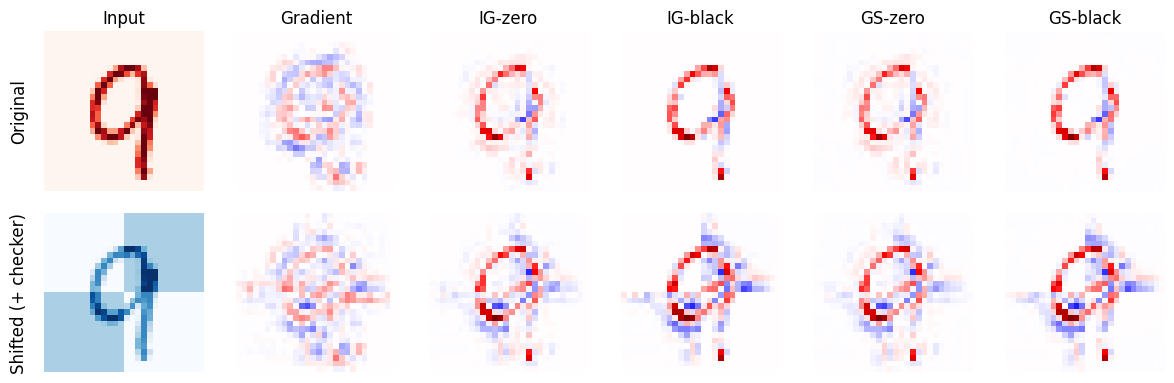

Gradient max|diff|=3.67e-01 mean|diff|=3.45e-02 RMSE=6.04e-02 relL1=106.93% corr=0.6167
IG-zero  max|diff|=2.91e-01 mean|diff|=2.30e-02 RMSE=4.59e-02 relL1=83.88% corr=0.9018
IG-black max|diff|=3.62e-01 mean|diff|=2.48e-02 RMSE=5.80e-02 relL1=95.10% corr=0.9008
GS-zero  max|diff|=2.54e-01 mean|diff|=2.28e-02 RMSE=4.50e-02 relL1=80.63% corr=0.9082
GS-black max|diff|=3.05e-01 mean|diff|=2.40e-02 RMSE=5.47e-02 relL1=94.36% corr=0.9157


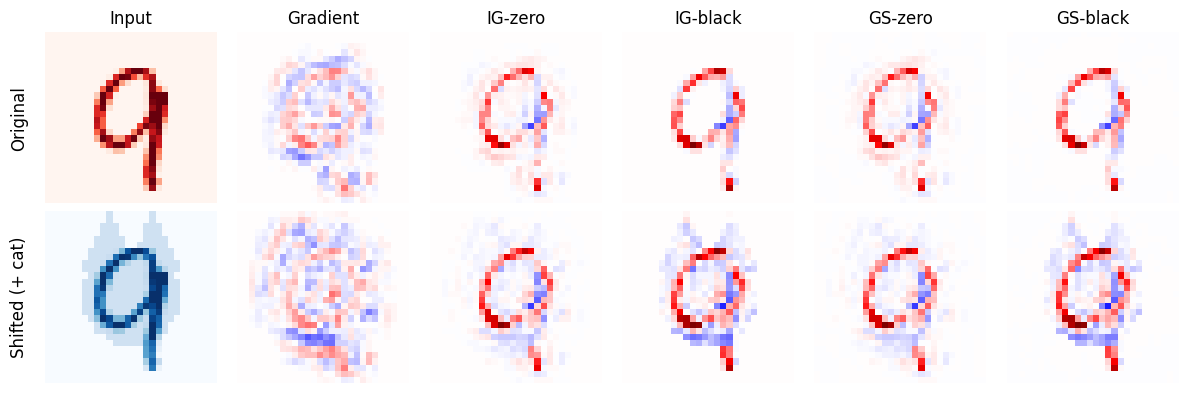

In [87]:
for label_shift in ['checker','cat']:
    m2 = make_shift(label_shift, raw_shift=0.5) 
    # verify model prediction unchanged
    pred_orig = model(x0).argmax().item()
    pred_shift = model(x0 + m2).argmax().item()
    assert pred_orig == pred_shift, f"Prediction changed under {label_shift} shift: {pred_orig} → {pred_shift}"

    attrs_orig  = compute_attrs(methods1, x0, shift_tensor=None, do_baseline_shift=False)
    base_attr_orig = attrs_orig.copy()
    attrs_shift = compute_attrs(methods1, x0, shift_tensor=m2, do_baseline_shift=False)
    base_attr_shifted = attrs_shift.copy()

    for name in rows:  # rows = list of method names
        m = invariance_metrics(attrs_orig[name], attrs_shift[name])
        print(f"{name:8s}",
            f"max|diff|={m['max_abs_diff']:.2e}",
            f"mean|diff|={m['mean_abs_diff']:.2e}",
            f"RMSE={m['rmse']:.2e}",
            f"relL1={m['rel_l1_error']:.2%}",
            f"corr={m['correlation']:.4f}")

    # denormalized images
    img_orig = (x0 * std + mean).cpu().squeeze().numpy()
    img_shift = ((x0 + m2) * std + mean).cpu().squeeze().numpy()

    # plot inputs + attributions
    fig, axes = plt.subplots(2, len(rows)+1, figsize=(2*(len(rows)+1), 4))
    # Input columns
    axes[0,0].imshow(img_orig, cmap='Reds',   vmin=0,  vmax=1); axes[0,0].axis('off'); axes[0,0].set_title('Input')
    axes[1,0].imshow(img_shift, cmap='Blues', vmin=img_shift.min(), vmax=img_shift.max()); axes[1,0].axis('off')

    # Attribution columns
    for j, name in enumerate(rows, start=1):
        axes[0,j].imshow(attrs_orig[name], cmap='seismic', vmin=-1, vmax=1)
        axes[0,j].axis('off'); axes[0,j].set_title(name)
        axes[1,j].imshow(attrs_shift[name], cmap='seismic', vmin=-1, vmax=1)
        axes[1,j].axis('off')

    # row labels
    axes[0,0].text(-0.1, 0.5, 'Original', transform=axes[0,0].transAxes, va='center', ha='right', rotation=90, fontsize=12)
    axes[1,0].text(-0.1, 0.5, 'Shifted' + f" (+ {label_shift})",  transform=axes[1,0].transAxes, va='center', ha='right', rotation=90, fontsize=12)

    plt.tight_layout()
    #plt.savefig(f"figures/ex3b_shift_{label_shift}.pdf", bbox_inches="tight")
    plt.show()

**Optional**, run multi-sample invariance statistics assessment
> Note: computationally heavy

In [88]:
# NOTE: Multi-sample checkerboard-shift invariance statistics
# def make_checker_shift(raw_shift: float = 0.30) -> torch.Tensor:
#     """Helper to build the 2x2 checkerboard shift (raw amplitude <= 0.30 preferred)"""
#     pattern = np.indices((28, 28)).sum(axis=0) % 2        # 0/1 checker mask
#     arr     = raw_shift * pattern.astype(np.float32)      # scale to amplitude
#     return torch.tensor(arr / std, device=device).unsqueeze(0).unsqueeze(0)

# checker = make_checker_shift()

# N = 100 # images to test
# rows_eval = ["Gradient", "IG-zero", "IG-black",
#              "GS-zero", "GS-black"]

# results_cb = {m: {k: [] for k in ["max_abs_diff",
#                                   "mean_abs_diff",
#                                   "rmse",
#                                   "rel_l1_error",
#                                   "correlation"]} for m in rows_eval}

# keep = 0
# with torch.no_grad():
#     for x, y in tqdm(islice(test_loader, N),
#                      total=N, desc="Checkerboard shift"):

#         x = x.to(device)

#         # prediction must remain unchanged
#         if model(x).argmax() != model(x + checker).argmax():
#             continue

#         keep += 1

#         attrs_orig  = compute_attrs(methods1, x, shift_tensor=None, do_baseline_shift=False, gs_n_samples=12800)

#         attrs_shift = compute_attrs(methods1, x, shift_tensor=checker, do_baseline_shift=False, gs_n_samples=12800)

#         for m in rows_eval:
#             r = invariance_metrics(attrs_orig[m], attrs_shift[m])
#             for k, v in r.items():
#                 results_cb[m][k].append(v)

# print(f"Evaluated {keep} / {N} images (skipped {N-keep} where logits changed)")

# # Aggregate and display 
# tbl_cb = []
# for m in rows_eval:
#     row = {"method": m}
#     for k, arr in results_cb[m].items():
#         arr = np.asarray(arr)
#         row[f"{k}_mean"] = arr.mean()
#         row[f"{k}_std"]  = arr.std()
#         row[f"{k}_p95"]  = np.percentile(arr, 95)
#     tbl_cb.append(row)

# df_cb = pd.DataFrame(tbl_cb)
# print(df_cb.to_string(index=False, float_format=lambda x: f"{x:.2e}"))

In [89]:
# Evaluated 99 / 100 images (skipped 1 where logits changed)
#   method  max_abs_diff_mean  max_abs_diff_std  max_abs_diff_p95  mean_abs_diff_mean  mean_abs_diff_std  mean_abs_diff_p95  rmse_mean  rmse_std  rmse_p95  rel_l1_error_mean  rel_l1_error_std  rel_l1_error_p95  correlation_mean  correlation_std  correlation_p95
# Gradient           2.27e-01          5.43e-02          3.24e-01            2.03e-02           3.61e-03           2.67e-02   3.69e-02  5.90e-03  4.66e-02           6.32e-01          6.76e-02          7.46e-01          7.96e-01         5.06e-02         8.62e-01
#  IG-zero           2.73e-01          7.62e-02          3.87e-01            1.75e-02           3.82e-03           2.40e-02   3.86e-02  7.57e-03  5.04e-02           6.64e-01          8.25e-02          8.13e-01          8.81e-01         3.51e-02         9.33e-01
# IG-black           3.02e-01          8.46e-02          4.28e-01            1.76e-02           4.18e-03           2.34e-02   4.24e-02  8.64e-03  5.59e-02           6.80e-01          1.11e-01          8.65e-01          9.08e-01         2.57e-02         9.40e-01
#  GS-zero           2.59e-01          7.20e-02          3.79e-01            1.69e-02           3.67e-03           2.33e-02   3.69e-02  7.33e-03  4.87e-02           6.48e-01          8.30e-02          8.15e-01          8.89e-01         3.25e-02         9.36e-01
# GS-black           2.88e-01          8.07e-02          4.13e-01            1.69e-02           3.96e-03           2.27e-02   4.02e-02  8.28e-03  5.31e-02           6.65e-01          1.11e-01          8.46e-01          9.14e-01         2.35e-02         9.44e-01


In [90]:
# print(df_cb.to_string(index=False))
# mean_abs_diff_p95  rmse_mean  rmse_std  rmse_p95  rel_l1_error_mean  rel_l1_error_std  rel_l1_error_p95  correlation_mean  correlation_std  correlation_p95
# Gradient           0.226533          0.054280          0.324424            0.020324           0.003605           0.026749   0.036916  0.005897  0.046568           0.631903          0.067552          0.746235          0.795736         0.050576         0.861625
#  IG-zero           0.273150          0.076189          0.387122            0.017523           0.003820           0.023956   0.038649  0.007567  0.050366           0.664230          0.082469          0.813256          0.880581         0.035149         0.933173
# IG-black           0.302221          0.084596          0.427924            0.017559           0.004181           0.023357   0.042429  0.008637  0.055946           0.679509          0.110665          0.864928          0.907977         0.025717         0.940237
#  GS-zero           0.259286          0.072047          0.379256            0.016930           0.003672           0.023292   0.036903  0.007326  0.048665           0.648291          0.083032          0.814669          0.888607         0.032466         0.936241
# GS-black           0.288250          0.080658          0.413404            0.016898           0.003962           0.022732   0.040210  0.008279  0.053131           0.665257          0.110872          0.845761          0.913965         0.023508         0.944061